# Multilingual Offline Forged  Signature Using Siamese Neural Network and Few-Shot Learning

2-ways 1-shot

In [1]:
!pip install keras

In [2]:
import numpy as np
import os
import cv2
import itertools
import random

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
import tensorflow as tf

from keras import backend as K
from keras.optimizers import Adam
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Lambda, GlobalAveragePooling2D, Subtract
from keras.layers import BatchNormalization, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.applications import DenseNet121
from keras.applications import ResNet50V2

import matplotlib.pyplot as plt
import numpy as np
from skimage.metrics import structural_similarity as ssim

In [3]:
# Paths to Datasets
cedar_path = "/content/drive/MyDrive/Multilingual dataset/CEDAR"
bengali_path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali"
hindi_path = "/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi"

# All the images will be converted to the same size before processing
img_h, img_w = 120, 120

# Preprocessing Function
def preprocess_image(img_path):
    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Read image in grayscale
    if image is None or len(image) == 0 or image.shape[0] == 0 or image.shape[1] == 0:
        print(f"Error: Image {img_path} is empty or None or has invalid dimensions.")
        return None
    image = cv2.resize(image, (img_h, img_w))
    image = cv2.merge((image, image, image))  # Convert grayscale to RGB
    image = image.astype('float32') / 255.0  # Normalize pixel values
    return image

# Load Data Function
def load_data(path, forged_count, genuine_count):
    dir_list = next(os.walk(path))[1]
    orig_groups, forg_groups = [], []
    for directory in dir_list:
        images = os.listdir(os.path.join(path, directory))
        images.sort()
        images = [os.path.join(path, directory, x) for x in images]
        forg_groups.append(images[:forged_count])
        orig_groups.append(images[forged_count:forged_count + genuine_count])
    return orig_groups, forg_groups

# Number of shots (images) for each class
shots_per_class = 1

# Total Number of genuine and forged images per folder of CEDAR, Bengali, and Hindi datasets
cedar_forged_count = 24
cedar_genuine_count = 24
bengali_forged_count = 30
bengali_genuine_count = 24
hindi_forged_count = 30
hindi_genuine_count = 24

# Load data with specified counts
orig_cedar, forg_cedar = load_data(cedar_path, cedar_forged_count, cedar_genuine_count)
orig_bengali, forg_bengali = load_data(bengali_path, bengali_forged_count, bengali_genuine_count)
orig_hindi, forg_hindi = load_data(hindi_path, hindi_forged_count, hindi_genuine_count)

# Randomly choose N-shots from each folder
random.seed(42)  # For reproducibility
random_forg_cedar = [random.sample(forg, shots_per_class) for forg in forg_cedar]
random_orig_cedar = [random.sample(orig, shots_per_class) for orig in orig_cedar]
random_forg_bengali = [random.sample(forg, shots_per_class) for forg in forg_bengali]
random_orig_bengali = [random.sample(orig, shots_per_class) for orig in orig_bengali]
random_forg_hindi = [random.sample(forg, shots_per_class) for forg in forg_hindi]
random_orig_hindi = [random.sample(orig, shots_per_class) for orig in orig_hindi]

# Combine Data
orig_groups = random_orig_cedar + random_orig_bengali + random_orig_hindi
forg_groups = random_forg_cedar + random_forg_bengali + random_forg_hindi

# Split Data into Train, Validation, and Test Sets
orig_train, orig_val_test, forg_train, forg_val_test = train_test_split(orig_groups, forg_groups, test_size=0.2, random_state=42)
orig_val, orig_test, forg_val, forg_test = train_test_split(orig_val_test, forg_val_test, test_size=0.5, random_state=42)

# Generate Batch Function
def generate_batch(orig_groups, forg_groups, batch_size=32):
    while True:
        pairs = [np.zeros((batch_size, img_h, img_w, 3)) for _ in range(2)]
        targets = np.zeros((batch_size,))

        for i in range(batch_size):
            if i < batch_size // 2:
                # Genuine-Genuine pairs
                pair_idx = np.random.randint(len(orig_groups), size=2)
                pair = (np.random.choice(orig_groups[pair_idx[0]]), np.random.choice(orig_groups[pair_idx[1]]))
                targets[i] = 1
            else:
                # Genuine-Forged pairs
                orig_idx = np.random.randint(len(orig_groups))
                orig = np.random.choice(orig_groups[orig_idx])
                forg = np.random.choice(forg_groups[orig_idx])
                pair = (orig, forg)
                targets[i] = 0

            img1 = preprocess_image(pair[0])
            img2 = preprocess_image(pair[1])

            pairs[0][i, :, :, :] = img1
            pairs[1][i, :, :, :] = img2

        yield pairs, targets

# Define batch size and generators
batch_size = 32
train_batch_generator = generate_batch(orig_train, forg_train, batch_size=batch_size)
val_batch_generator = generate_batch(orig_val_test, forg_val_test, batch_size=batch_size)
test_batch_generator = generate_batch(orig_test, forg_test, batch_size=batch_size)

def get_siamese_model(input_shape):
    input_a = Input(shape=input_shape)
    input_b = Input(shape=input_shape)

    # Base CNN model
    base_model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu')
    ])

    processed_a = base_model(input_a)
    processed_b = base_model(input_b)

    L1_distance = Lambda(lambda tensors: K.abs(tensors[0] - tensors[1]))([processed_a, processed_b])
    similarity = Dense(1, activation='sigmoid')(L1_distance)

    model = Model(inputs=[input_a, input_b], outputs=similarity)
    return model

input_shape = (img_h, img_w, 3)
model = get_siamese_model(input_shape)
model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])
# Define Callbacks
callbacks = [
    EarlyStopping(patience=4, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint('/content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/2-ways 1shot-{epoch:03d}.h5',
                    verbose=1, save_best_only=True, save_weights_only=True)
]

# Train Model
num_train_samples = sum(len(group) for group in orig_train + forg_train)
num_val_samples = sum(len(group) for group in orig_val_test + forg_val_test)
steps_per_epoch_train = max(1, num_train_samples // batch_size)
steps_per_epoch_val = max(1, num_val_samples // batch_size)

results = model.fit(
    train_batch_generator,
    steps_per_epoch=steps_per_epoch_train,
    epochs=5,
    validation_data=val_batch_generator,
    validation_steps=steps_per_epoch_val,
    callbacks=callbacks
)

Epoch 1/5
15/15 [==============================] - ETA: 0s - loss: 0.6742 - accuracy: 0.6042
Epoch 1: val_loss improved from inf to 0.66992, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/2-ways 1shot-001.h5
15/15 [==============================] - 22s 1s/step - loss: 0.6742 - accuracy: 0.6042 - val_loss: 0.6699 - val_accuracy: 0.5521 - lr: 1.0000e-04
Epoch 2/5
15/15 [==============================] - ETA: 0s - loss: 0.6385 - accuracy: 0.6333
Epoch 2: val_loss improved from 0.66992 to 0.66361, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/2-ways 1shot-002.h5
15/15 [==============================] - 18s 1s/step - loss: 0.6385 - accuracy: 0.6333 - val_loss: 0.6636 - val_accuracy: 0.5417 - lr: 1.0000e-04
Epoch 3/5
15/15 [==============================] - ETA: 0s - loss: 0.6090 - accuracy: 0.6604
Epoch 3: val_loss improved from 0.66361 to 0.64899, saving model to /content/drive/MyDrive/Multilingual dataset/Weights/2-way

In [4]:
# Summary of the model
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 120, 120, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 512)                  1116934   ['input_1[0][0]',             
                                                          4          'input_2[0][0]']             
                                                                                                  
 lambda (Lambda)             (None, 512)                  0         ['sequential[0][0]',      

In [6]:
# Load best weights
model.load_weights('/content/drive/MyDrive/Multilingual dataset/Weights/2-ways 1-shot/2-ways 1shot-004.h5')

In [7]:
# Example: Predict on test data (replace with actual test data)
test_batch_inputs, test_batch_labels = next(test_batch_generator)
predictions = model.predict(test_batch_inputs)

# Function to compute ROC curve
def compute_roc_curve(predictions, labels):
    fpr, tpr, thresholds = roc_curve(labels, predictions)  # Use predictions directly
    roc_auc = auc(fpr, tpr)
    return fpr, tpr, thresholds, roc_auc

# Compute ROC curve
fpr, tpr, thresholds, roc_auc = compute_roc_curve(predictions, test_batch_labels)

# Find the optimal threshold using Youden's J statistic
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]

# Apply the optimal threshold to predictions
predictions_binary = (predictions >= optimal_threshold).astype(int)

# Calculate metrics using the optimal threshold
accuracy = accuracy_score(test_batch_labels, predictions_binary)
precision = precision_score(test_batch_labels, predictions_binary)
recall = recall_score(test_batch_labels, predictions_binary)
f1 = f1_score(test_batch_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-Score:", f1)
print("Optimal Threshold:", optimal_threshold)
print("ROC AUC:", roc_auc)

1/1 [==============================] - 1s 591ms/step
Accuracy: 0.78125
Precision: 0.7142857142857143
Recall: 0.9375
F1-Score: 0.8108108108108109
Optimal Threshold: 0.464231
ROC AUC: 0.7421875


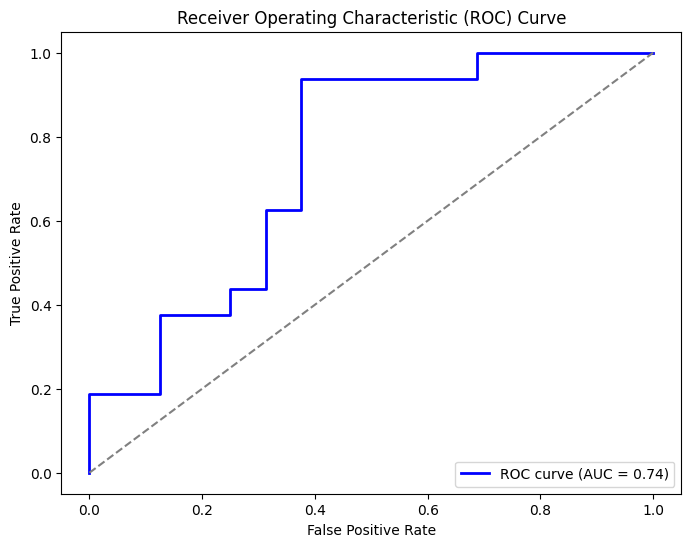

In [8]:
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(test_batch_labels, predictions)

# Compute ROC AUC
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

1/1 [==============================] - 0s 53ms/step


<ipython-input-9-f8cf05e75744>:11: FutureWarning: `multichannel` is a deprecated argument name for `structural_similarity`. It will be removed in version 1.0. Please use `channel_axis` instead.
  ssim_score = ssim(img1, img2, multichannel=True)


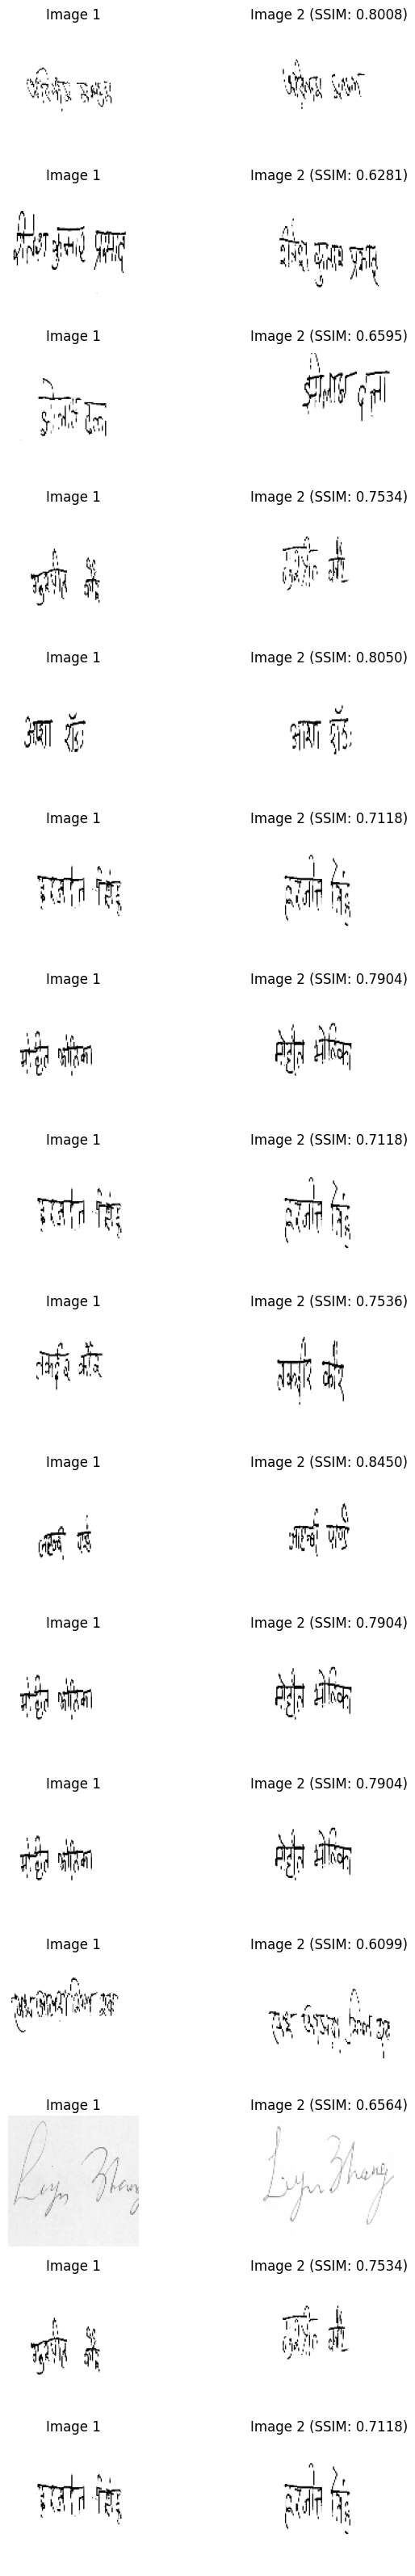

Average SSIM score: 0.7357208177594189


In [9]:
def display_genuine_forged_with_ssim(model, test_batch_generator, num_pairs=16):
    test_batch_inputs, test_batch_labels = next(test_batch_generator)
    predictions = model.predict(test_batch_inputs)

    fig, axes = plt.subplots(num_pairs, 2, figsize=(8, 2*num_pairs))
    genuine_forged_pairs = [(test_batch_inputs[0][i], test_batch_inputs[1][i], test_batch_labels[i]) for i in range(len(test_batch_labels)) if test_batch_labels[i] == 0]

    ssim_scores = []
    for i in range(num_pairs):
        img1, img2, label = genuine_forged_pairs[i]
        ssim_score = ssim(img1, img2, multichannel=True)
        ssim_scores.append(ssim_score)

        axes[i, 0].imshow(img1)
        axes[i, 0].set_title(f"Image 1")
        axes[i, 0].axis('off')

        axes[i, 1].imshow(img2)
        axes[i, 1].set_title(f"Image 2 (SSIM: {ssim_score:.4f})")
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

    # Calculate average SSIM score
    average_ssim = np.mean(ssim_scores)
    print("Average SSIM score:", average_ssim)

# Call the function to display genuine-forged image pairs with SSIM scores and print the average SSIM score
display_genuine_forged_with_ssim(model, test_batch_generator)

**Above Threshold:** If the similarity score is above the threshold, classify the pair as similar.


**Below Threshold:** If the similarity score is below the threshold, classify the pair as dissimilar.

1/1 [==============================] - 0s 29ms/step
Original Image: B-S-99-G-02.tif
Forged Image: B-S-99-F-12.tif


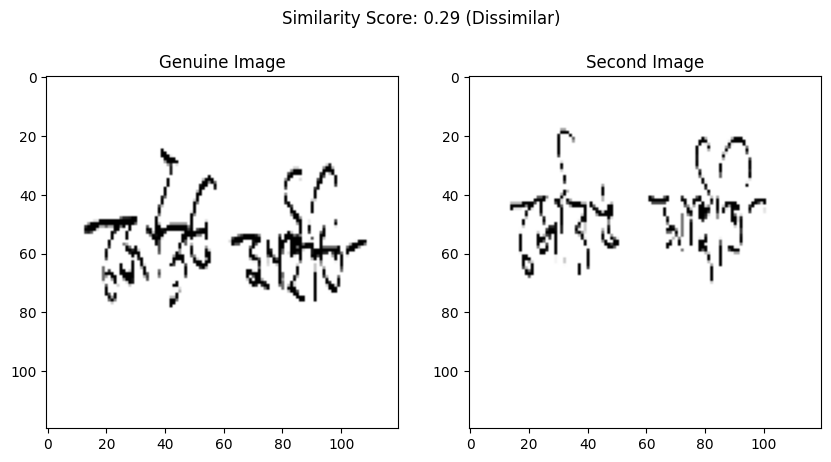

In [56]:
def show_similarity_score(model, orig_groups, forg_groups, img_h, img_w):
    # Select a random genuine image index
    orig_idx = np.random.randint(len(orig_groups))
    orig_group = orig_groups[orig_idx]
    orig_index = np.random.randint(len(orig_group))
    orig = orig_group[orig_index]
    orig_name = orig.split('/')[-1]  # Extract the file name

    # Select a random forged image index
    forg_group = forg_groups[orig_idx]
    forg_index = np.random.randint(len(forg_group))
    forg = forg_group[forg_index]
    forg_name = forg.split('/')[-1]  # Extract the file name of the forged image

    # Preprocess the images
    img1 = preprocess_image(orig)
    img2 = preprocess_image(forg)

    # Reshape the images for model input
    img1 = img1.reshape(1, img_h, img_w, 3)
    img2 = img2.reshape(1, img_h, img_w, 3)

    # Compute similarity score
    similarity_score = model.predict([img1, img2])[0][0]

    # Determine similarity or dissimilarity based on threshold
    if similarity_score >= optimal_threshold:
        similarity = "Similar"
    else:
        similarity = "Dissimilar"

    # Print file names
    print("Original Image:", orig_name)
    print("Forged Image:", forg_name)

    # Display the pair of images along with their similarity score
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img1.squeeze())
    plt.title('Genuine Image')
    plt.text(0, -10, orig_name, color='white', fontsize=12, ha='left', va='top')  # Add file name at the top
    plt.subplot(1, 2, 2)
    plt.imshow(img2.squeeze())
    plt.title('Second Image')
    plt.text(0, -10, forg_name, color='white', fontsize=12, ha='left', va='top')  # Add file name at the top
    plt.suptitle('Similarity Score: {:.2f} ({})'.format(similarity_score, similarity))
    plt.show()

# Example usage
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)


1/1 [==============================] - 0s 51ms/step
Original Image: original_24_12.png
Forged Image: forgeries_24_15.png


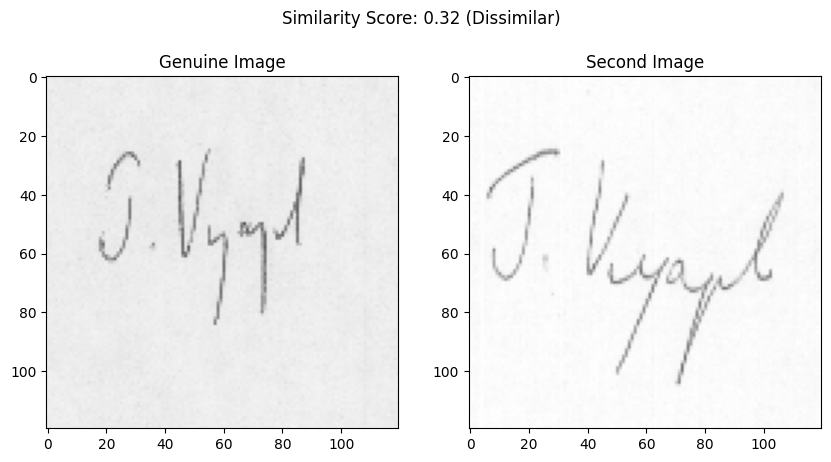

In [57]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 36ms/step
Original Image: B-S-43-G-21.tif
Forged Image: B-S-43-F-02.tif


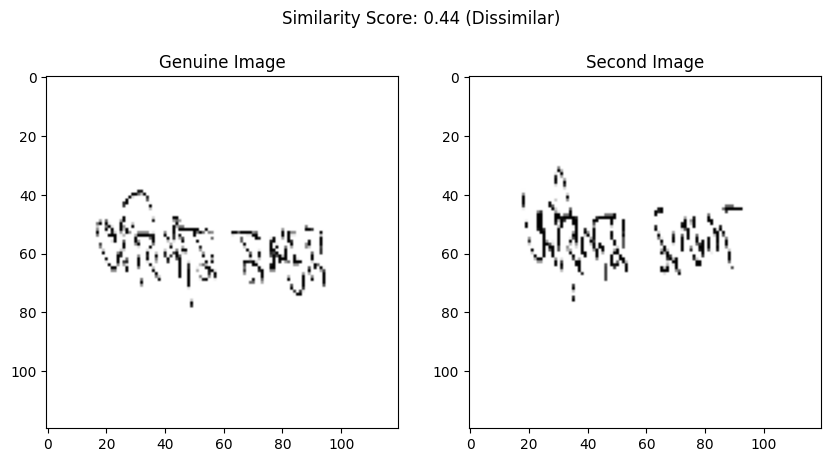

In [58]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 19ms/step
Original Image: H-S-47-G-13.tif
Forged Image: H-S-47-F-09.tif


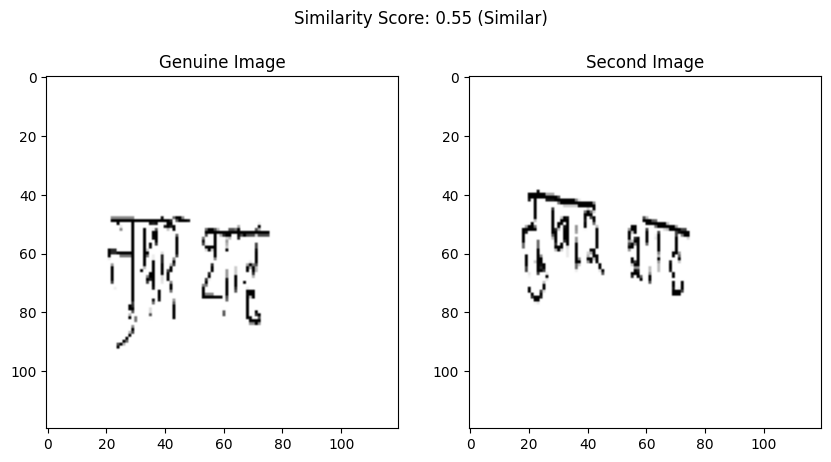

In [59]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 19ms/step
Original Image: B-S-91-G-22.tif
Forged Image: B-S-91-F-17.tif


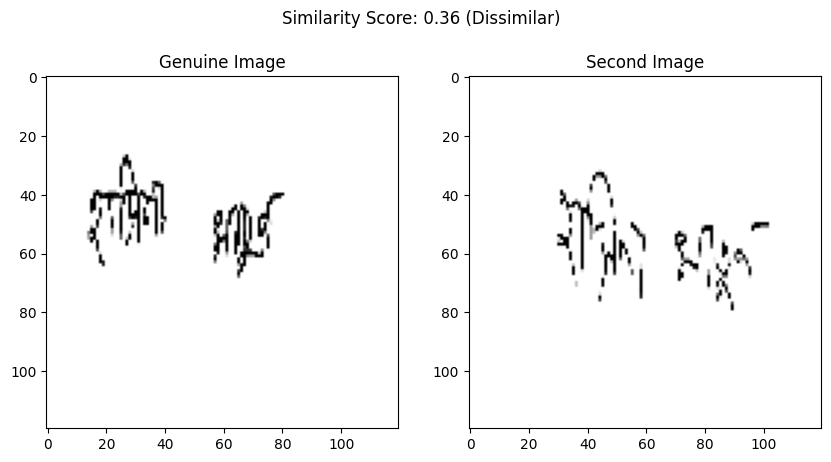

In [60]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 19ms/step
Original Image: H-S-131-G-18.tif
Forged Image: H-S-131-F-28.tif


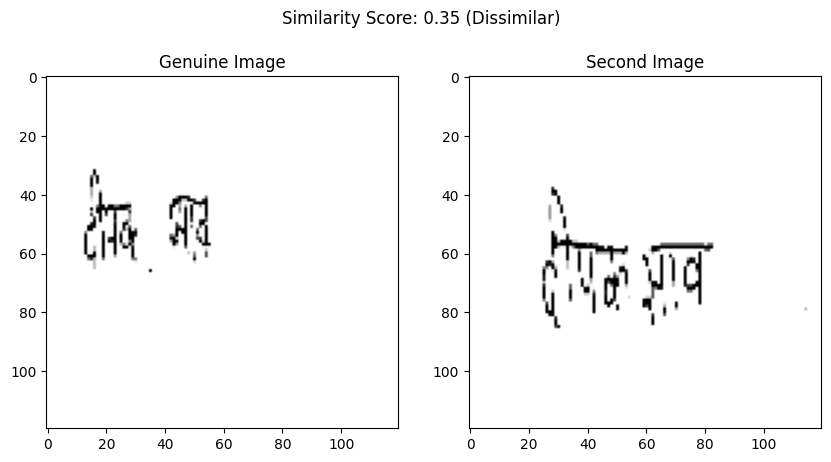

In [61]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 33ms/step
Original Image: B-S-61-G-21.tif
Forged Image: B-S-61-F-01.tif


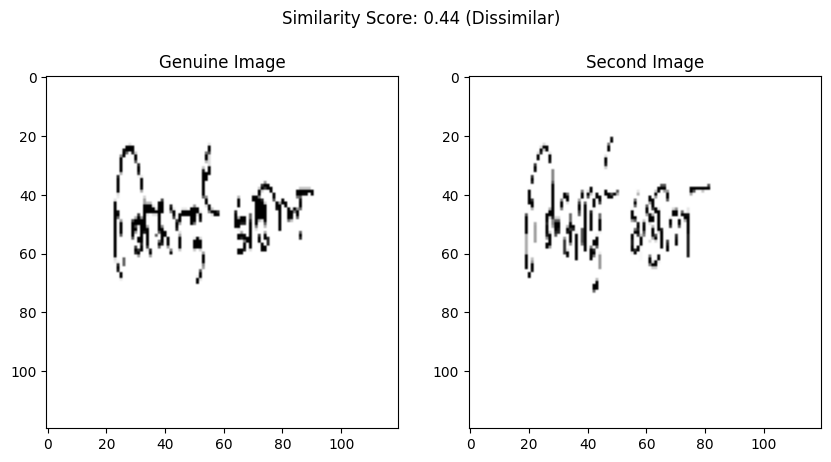

In [62]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 27ms/step
Original Image: H-S-146-G-18.tif
Forged Image: H-S-146-F-10.tif


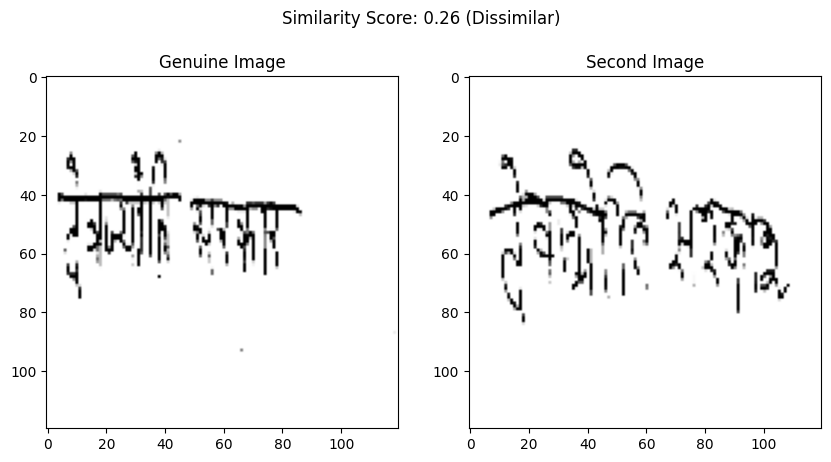

In [63]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 18ms/step
Original Image: B-S-85-G-14.tif
Forged Image: B-S-85-F-21.tif


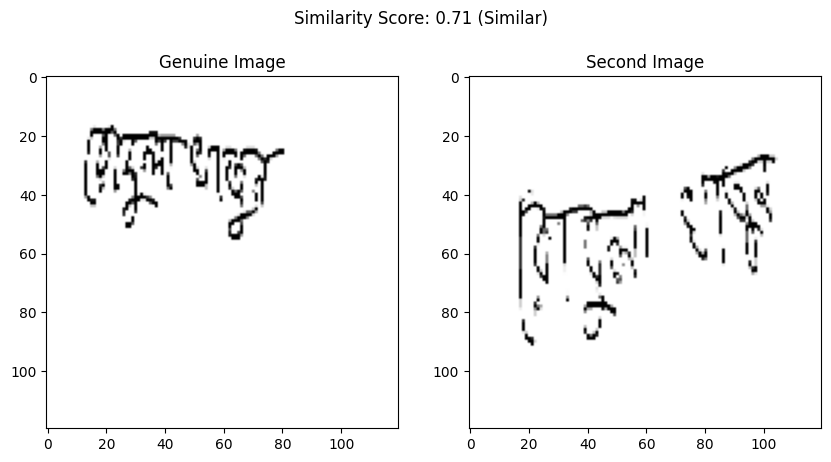

In [64]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 20ms/step
Original Image: B-S-9-G-04.tif
Forged Image: B-S-9-F-25.tif


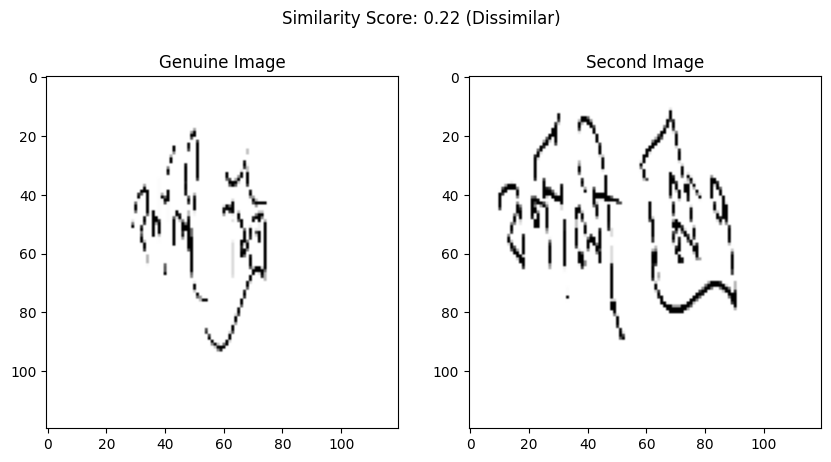

In [68]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 19ms/step
Original Image: B-S-62-G-02.tif
Forged Image: B-S-62-F-22.tif


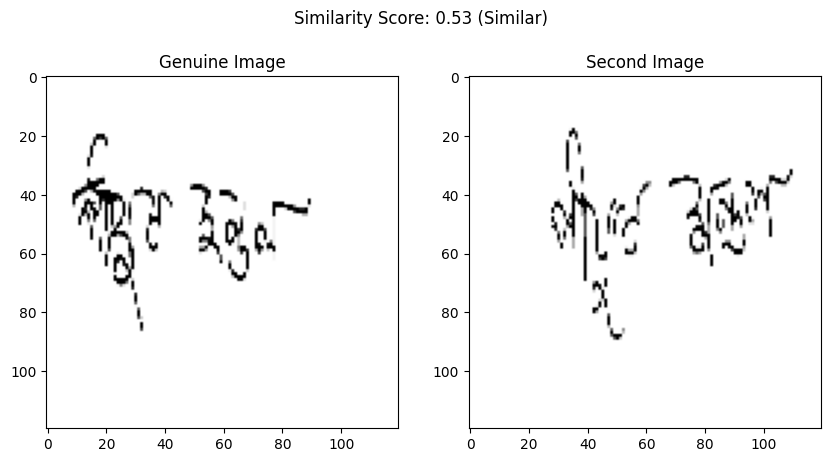

In [67]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 18ms/step
Original Image: original_30_6.png
Forged Image: forgeries_30_1.png


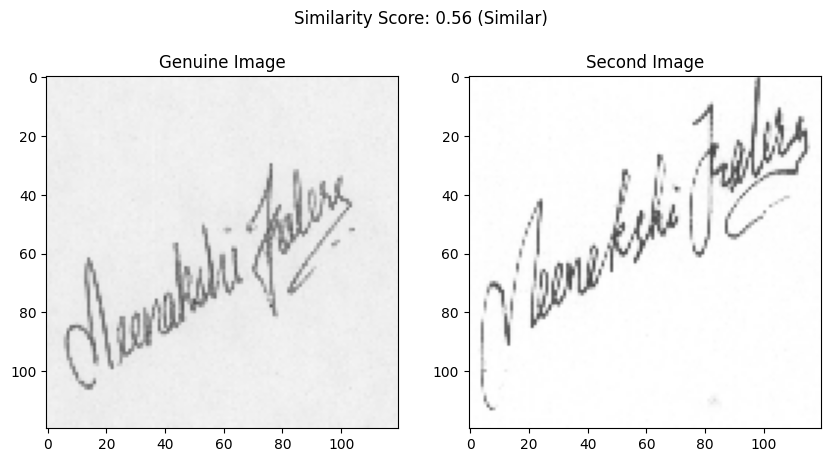

In [72]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 29ms/step
Original Image: H-S-1-G-05.tif
Forged Image: H-S-1-F-07.tif


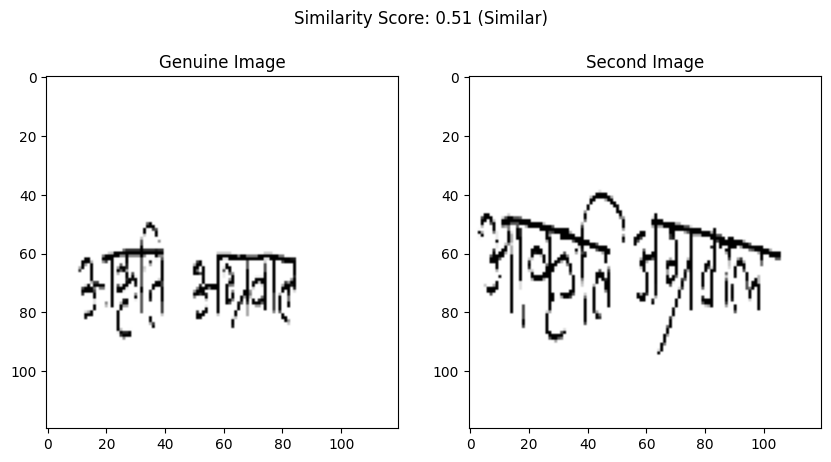

In [71]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 27ms/step
Original Image: H-S-110-G-21.tif
Forged Image: H-S-110-F-28.tif


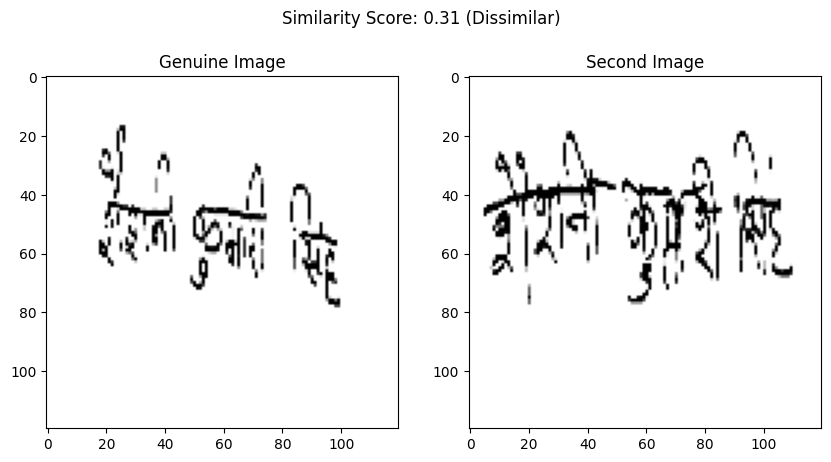

In [70]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 27ms/step
Original Image: H-S-77-G-22.tif
Forged Image: H-S-77-F-29.tif


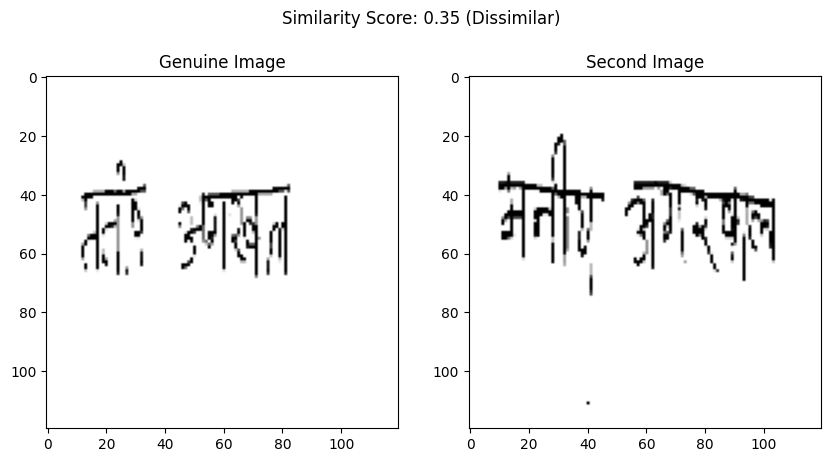

In [69]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 19ms/step
Original Image: H-S-130-G-18.tif
Forged Image: H-S-130-F-02.tif


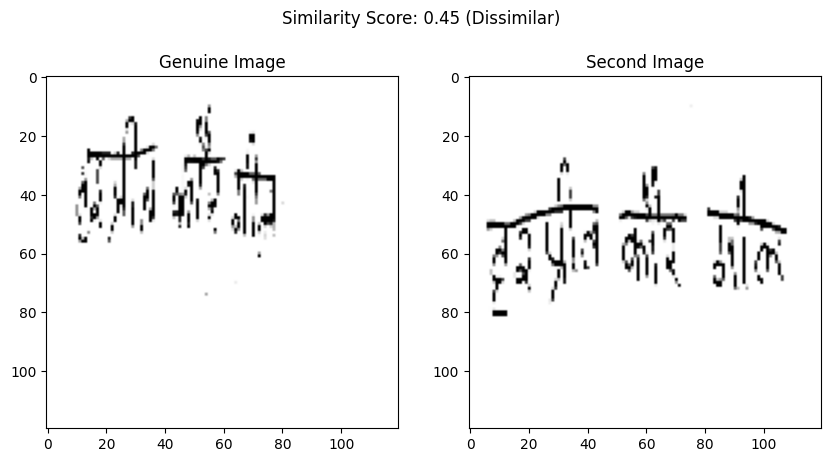

In [77]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 23ms/step
Original Image: H-S-13-G-05.tif
Forged Image: H-S-13-F-09.tif


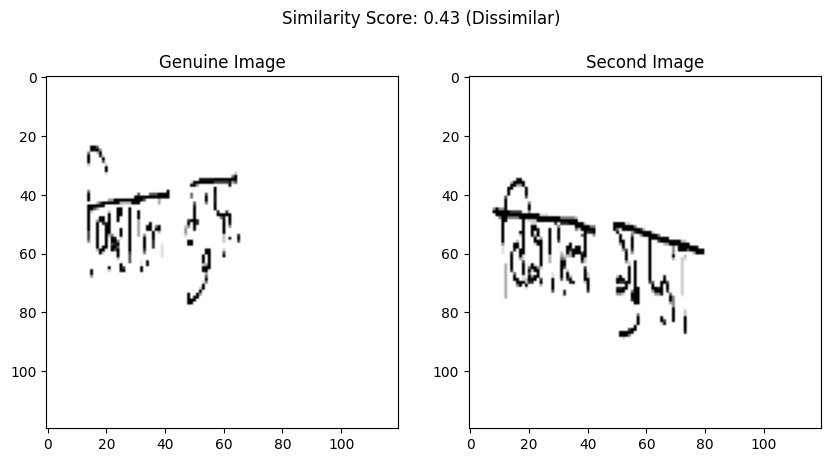

In [76]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 19ms/step
Original Image: B-S-77-G-16.tif
Forged Image: B-S-77-F-24.tif


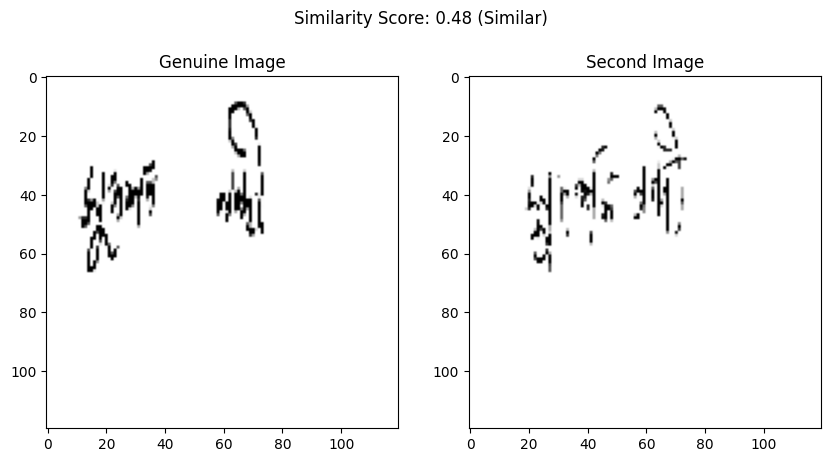

In [75]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 77ms/step
Original Image: B-S-73-G-05.tif
Forged Image: B-S-73-F-14.tif


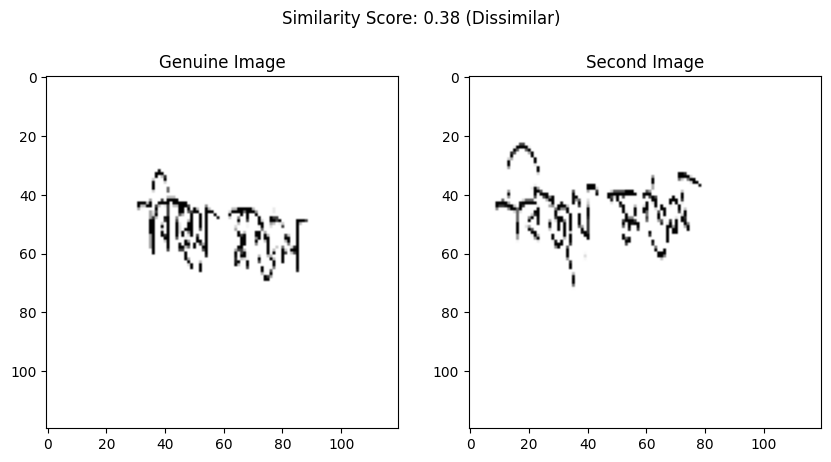

In [74]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

1/1 [==============================] - 0s 20ms/step
Original Image: B-S-75-G-08.tif
Forged Image: B-S-75-F-29.tif


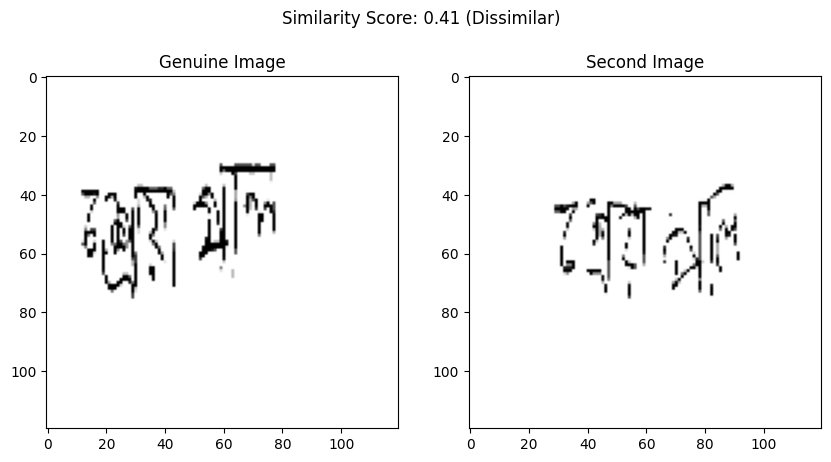

In [73]:
show_similarity_score(model, orig_groups, forg_groups, img_h, img_w)

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.lines as mlines

# Convert predictions to binary values (0 or 1) using optimal_threshold
binary_predictions = np.where(predictions >= optimal_threshold, 1, 0)

# Define colors for correct and incorrect predictions
colors = ['orange' if pred == label else 'red' for pred, label in zip(binary_predictions, test_batch_labels)]

# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(range(len(predictions)), predictions.flatten(), color=colors)
plt.ylabel('Predicted Probability')
plt.title('Predicted Probabilities vs. Ground Truth Labels')
plt.xticks(range(len(predictions)))

# Add a horizontal line indicating the threshold
plt.axhline(y=optimal_threshold, color='black', linestyle='--', linewidth=1, label='Threshold')

# Add legend with correct and incorrect prediction labels
correct_patch = mpatches.Patch(color='orange', label='Correct Prediction')
incorrect_patch = mpatches.Patch(color='red', label='Incorrect Prediction')
threshold_line = mlines.Line2D([], [], color='black', linestyle='--', label='Threshold')
plt.legend(handles=[correct_patch, incorrect_patch, threshold_line], loc='upper right')

plt.show()

# Print predictions and ground truth labels
print("Predictions:")
print(predictions)
print("Ground Truth Labels:")
print(test_batch_labels)


In [82]:
# Predict on test data
predictions = model.predict(test_batch_generator, steps=len(orig_test))

# Extract distances from predictions
distances = predictions.flatten()

# Print distances between pairs of images
for i, distance in enumerate(distances):
    pair_type = "Genuine" if i < len(distances) // 2 else "Forged"
    print(f"Pair {i+1}: Type: {pair_type}, Distance: {distance:.4f}")


32/32 [==============================] - 13s 405ms/step
Pair 1: Type: Genuine, Distance: 0.8151
Pair 2: Type: Genuine, Distance: 0.5109
Pair 3: Type: Genuine, Distance: 0.4734
Pair 4: Type: Genuine, Distance: 0.4987
Pair 5: Type: Genuine, Distance: 0.7919
Pair 6: Type: Genuine, Distance: 0.9515
Pair 7: Type: Genuine, Distance: 0.4229
Pair 8: Type: Genuine, Distance: 0.4067
Pair 9: Type: Genuine, Distance: 0.6089
Pair 10: Type: Genuine, Distance: 0.7402
Pair 11: Type: Genuine, Distance: 0.5394
Pair 12: Type: Genuine, Distance: 0.9470
Pair 13: Type: Genuine, Distance: 0.7936
Pair 14: Type: Genuine, Distance: 0.5968
Pair 15: Type: Genuine, Distance: 0.4674
Pair 16: Type: Genuine, Distance: 0.4569
Pair 17: Type: Genuine, Distance: 0.5509
Pair 18: Type: Genuine, Distance: 0.5499
Pair 19: Type: Genuine, Distance: 0.3312
Pair 20: Type: Genuine, Distance: 0.4613
Pair 21: Type: Genuine, Distance: 0.5575
Pair 22: Type: Genuine, Distance: 0.3751
Pair 23: Type: Genuine, Distance: 0.5509
Pair 24: T

In [83]:
# Print paths of all images in the test set
for orig_group, forg_group in zip(orig_test, forg_test):
    print("Originals:")
    for img_path in orig_group:
        print(img_path)
    print("Forged:")
    for img_path in forg_group:
        print(img_path)

Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-G-16.tif
Forged:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/112/H-S-112-F-04.tif
Originals:
/content/drive/MyDrive/Multilingual dataset/CEDAR/18/original_18_5.png
Forged:
/content/drive/MyDrive/Multilingual dataset/CEDAR/18/forgeries_18_13.png
Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/144/H-S-144-G-02.tif
Forged:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/144/H-S-144-F-26.tif
Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/31/B-S-31-G-16.tif
Forged:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/31/B-S-31-F-18.tif
Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/17/H-S-017-G-11.tif
Forged:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Hindi/17/H-S-017-F-17.tif
Originals:
/content/drive/MyDrive/Multilingual dataset/BHSig260-Bengali/62/B-S-62-G-02.tif
Forged:
/content/drive/MyDrive/M